In [22]:
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import shrimpy
%matplotlib inline 

In [73]:
#tickers

eth = pd.read_csv('eth.csv',parse_dates=True, index_col="date")
eth = eth['PriceUSD']

btc = pd.read_csv('btc.csv',parse_dates=True, index_col="date")
btc = btc['PriceUSD']

rep = pd.read_csv('rep.csv',parse_dates=True, index_col="date")
rep = rep['PriceUSD']
 

date
2016-10-04    12.416077
2016-10-05     9.195945
2016-10-06     6.273032
2016-10-07     6.186431
2016-10-08     5.267986
                ...    
2020-02-05    15.669385
2020-02-06    15.646541
2020-02-07    15.795386
2020-02-08    16.318706
2020-02-09    16.378582
Name: PriceUSD, Length: 1224, dtype: float64

In [74]:
#juntar todas as colunas close na mesma dataframe, embora sejam perdidos muitos dados
portfolio = pd.concat([btc,eth],axis=1)
portfolio.columns = ['btc','eth']

In [75]:
#retorno log
log_ret=np.log(portfolio/portfolio.shift(1))

In [76]:
#simulação de montecarlo embora esta parte seja mais para apresentar um grafico final

num_ports = 5000

all_weights = np.zeros((num_ports,len(portfolio.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(2))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *365)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 365, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [77]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 365
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 365, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [78]:
def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1 

In [79]:
def check_sum(weights):
    #return 0 if the sum of the weights is 1
    return np.sum(weights) -1 

In [80]:
cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1))
init_guess = [0.25,0.25]

In [81]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [82]:
opt_results

     fun: -1.287877903927417
     jac: array([ 2.16066837e-06, -4.36604023e-06])
 message: 'Optimization terminated successfully.'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.66742095, 0.33257905])

In [83]:
#aqui está a array com os pesos da carteira que devemos ter para maximizar o valor do sharpe ratio
opt_results.x

array([0.66742095, 0.33257905])

In [84]:
#a partir desta parte, é codigo para trabalhar a parte ilustrativa de forma a melhor visulizar os resultados 
get_ret_vol_sr(opt_results.x)

array([1.18438915, 0.91964397, 1.2878779 ])

In [85]:
x = get_ret_vol_sr(opt_results.x)[0]
y = get_ret_vol_sr(opt_results.x)[1]

In [86]:
frontier_y= np.linspace(0,0.3,100)

In [87]:
def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

In [88]:
frontier_volatility = []
for possible_return in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w: get_ret_vol_sr(w)[0]-possible_return})
    result = minimize(minimize_vol,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

Compra 66.74209513263128 % de BTC
Compra 33.25790486736872 % de ETH


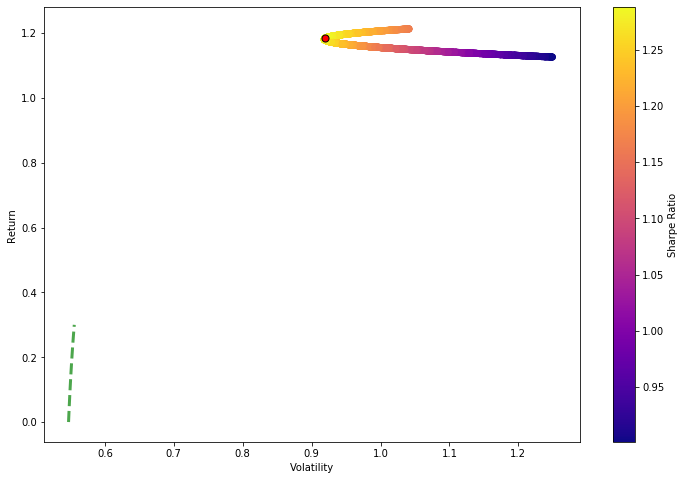

In [89]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3,alpha=0.7)

plt.scatter(y,x,c='red',s=50,edgecolors='black')

print('Compra', opt_results.x[0] * 100,'% de BTC')
print('Compra', opt_results.x[1] * 100,'% de ETH')





In [21]:
#PROBLEMA: os dados apresentam rentabilidades negativas. Desta forma não é possivel de aplicar o modelo de markowitz
#Solução : ir buscar dados com mais histórico : coinmarketcap https://pypi.org/project/coinmarketcap/
